In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn import OneHotEncoder

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [2]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [3]:
seed = 3
np.random.seed(seed)
net = Network(MSE(1), eta=1e-4)

net.add_layer(
    input_size=len(X_train[0]),
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=ReLU(),
    momentum=('Standard',1e-5)
)


net.add_layer(
    input_size=16,
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)
net.add_layer(
    input_size=16,
    units_size=3,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)

('Standard', 1e-05)
('Standard', 1e-05)
('Standard', 1e-05)


In [4]:
seed = 3

net = create_all_net(
    seed=seed,
    loss="MSE",
    batch_size=1,
    input_size=len(X_train[0]),
    num_layer=3,
    layers_size=[16,16,3],
    starting=["Range_random", "Range_random", "Range_random"],
    starting_range=[(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)],
    activations=["ReLU", "ReLU", "Identity"],
    regularizers=["L2", "None", "L2"],
    regularizers_lambda=[1e-6,0,1e-6],
    momentums=[("Standard", 1e-5), ("None", 0), ("Standard", 1e-5)],
    eta=1e-4
)

('Standard', 1e-05)
None
('Standard', 1e-05)


In [55]:

regularizers=["L2", "None", "L2"]
regularizers_lambda=[1e-6,0,1e-6]
regularizers_ = []

for i, reg in enumerate(regularizers):
    print(reg)
    if reg != "None":
        regularizers_.append(eval(reg)(lambda_=regularizers_lambda[i]))
    else:
        regularizers_.append(None)

for i in regularizers_:
    print(type(i))

L2
None
L2
<class 'regularizers.L2'>
<class 'NoneType'>
<class 'regularizers.L2'>


In [8]:
print(net)
type(net.loss)


Network: 3 layers 
Loss: MSE


str

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epochs: 100%|██████████| 1000/1000 [02:05<00:00,  7.94it/s]


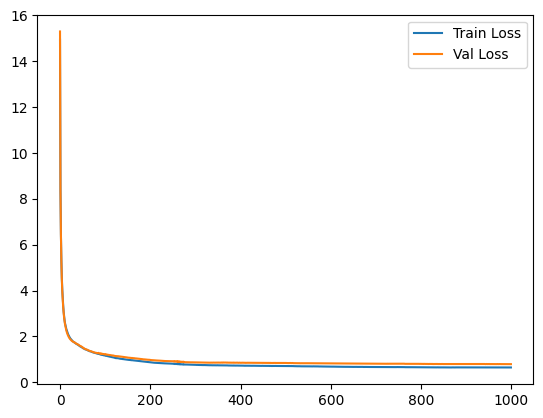

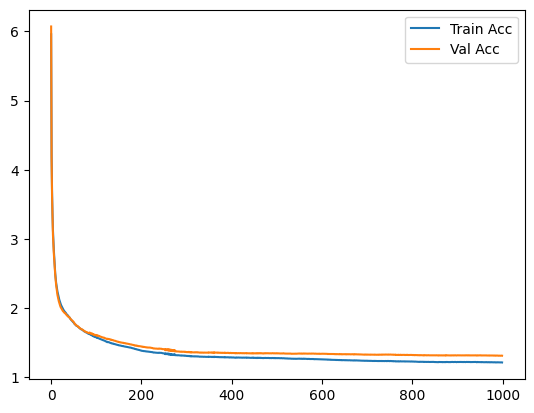

('Standard', 1e-05)
None
('Standard', 1e-05)


Epochs:  40%|███▉      | 397/1000 [00:53<01:21,  7.42it/s]


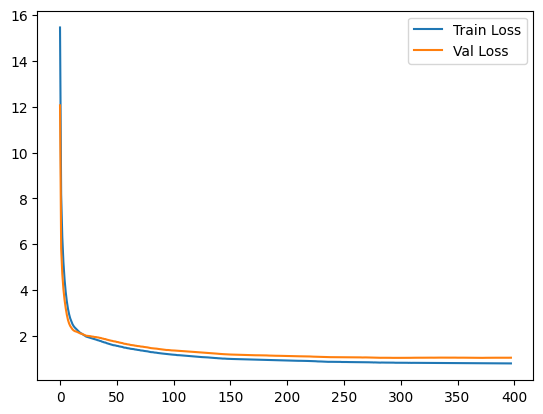

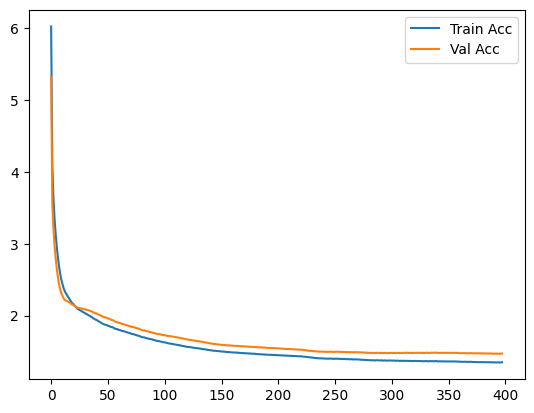

('Standard', 1e-05)
None
('Standard', 1e-05)


Epochs: 100%|██████████| 1000/1000 [02:27<00:00,  6.80it/s]


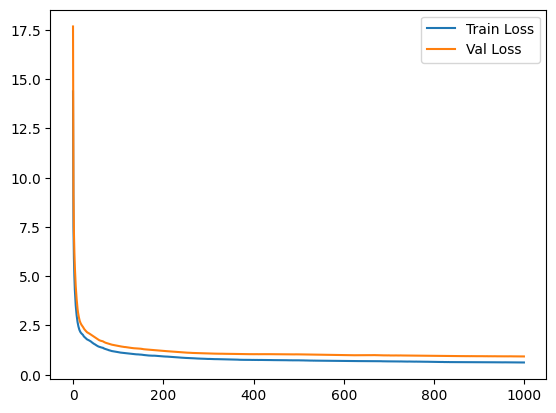

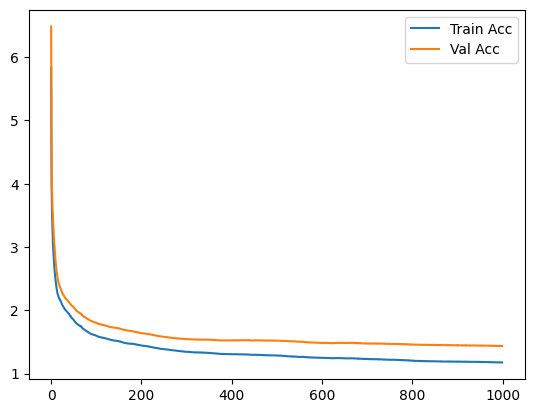

('Standard', 1e-05)
None
('Standard', 1e-05)


Epochs: 100%|██████████| 1000/1000 [02:20<00:00,  7.11it/s]


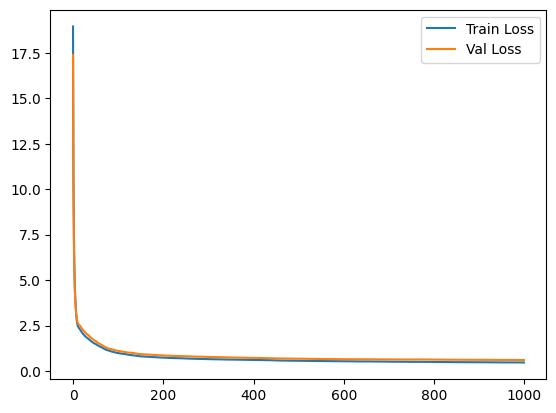

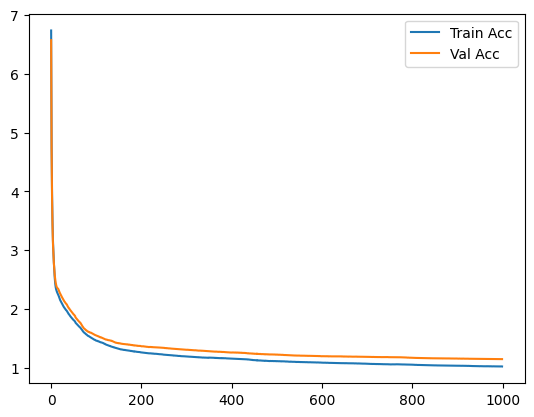

('Standard', 1e-05)
None
('Standard', 1e-05)


Epochs: 100%|██████████| 1000/1000 [01:59<00:00,  8.35it/s]


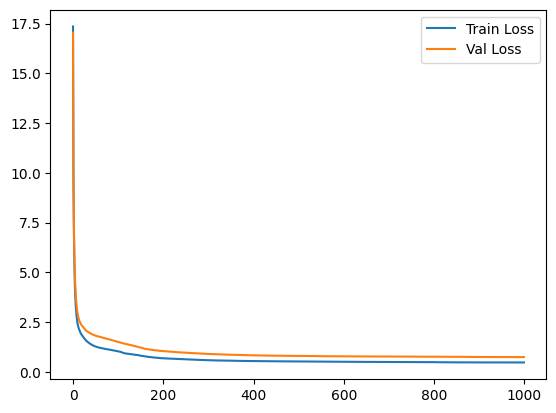

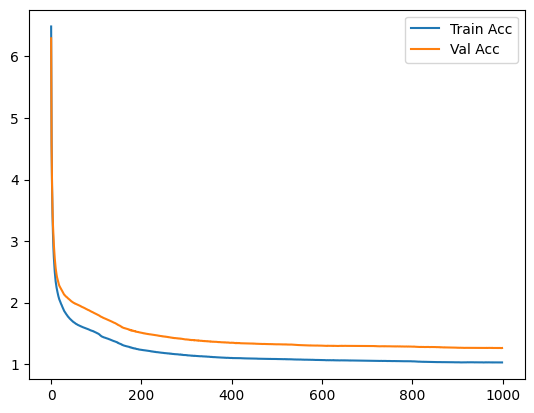

('Standard', 1e-05)
None
('Standard', 1e-05)


Epochs: 100%|██████████| 1000/1000 [02:00<00:00,  8.32it/s]


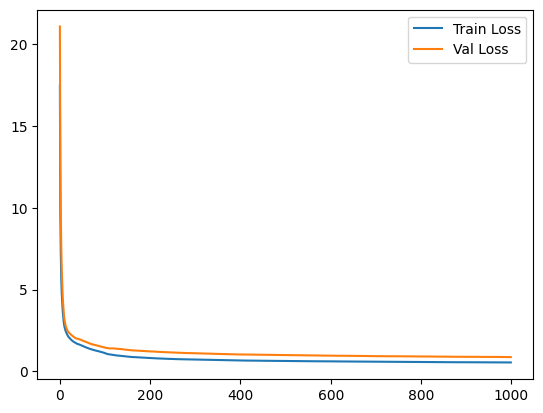

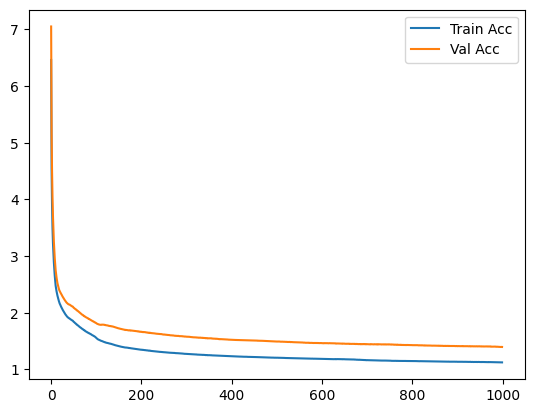

('Standard', 1e-05)
None
('Standard', 1e-05)
{'tr_loss': 0.5947590897109998, 'tr_metric': 1.152595354875999, 'val_loss': 0.83400560690031, 'val_metric': 1.3380531157917355}


In [5]:
statistics = kfold_crossval(
    X=X_train,
    y=y_train,
    k=6,
    net=net,
    epochs=1000,
    patience=100,
    seed=seed,
    metric=MEE()
)

print(statistics)

In [35]:
import itertools

# define the hyperparameters
losses = ["MSE"]
#batch_sizes = [1, 10]
layers_sizes = [[16,16,3]]
startings = ["Range_random", "Range_random", "Range_random"]
startings_range = [(-0.5,0.5)]

activations = ["ReLU"]
regularizers = ["L1"]
regularizers_lambda = [1e-4, 1e-6]
momentums = [('Standard',1e-6)]
etas = [1e-4]

# create a list of all the possible combinations
hyperparameters = [losses, layers_sizes, startings,
                activations, regularizers, regularizers_lambda,
                momentums, startings_range, etas]
hyperparameters = list(itertools.product(*hyperparameters))
hyperparameters






[('MSE',
  [16, 16, 3],
  'Range_random',
  'ReLU',
  'L1',
  0.0001,
  ('Standard', 1e-06),
  (-0.5, 0.5),
  0.0001),
 ('MSE',
  [16, 16, 3],
  'Range_random',
  'ReLU',
  'L1',
  1e-06,
  ('Standard', 1e-06),
  (-0.5, 0.5),
  0.0001)]

In [33]:
losses_ = "MSE"
layers_sizes_ = [16,16,3]

startings_ = []
startings_range_ = []
activations_ = []
regularizers_ = []
regularizers_lambda_ = []
momentums_ = []


for h in range(len(hyperparameters)):
    startings_ = []
    activations_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    startings_range_ = []
    etas_ = hyperparameters[h][8]
    for i in range(len(layers_sizes[0])):
        activations_.append(hyperparameters[h][3] if i != len(layers_sizes[0])-1 else "Identity")
        startings_.append(hyperparameters[h][2])
        startings_range_.append(hyperparameters[h][7])
        regularizers_.append(hyperparameters[h][4])
        regularizers_lambda_.append(hyperparameters[h][5])
        momentums_.append(hyperparameters[h][6])
    
    print(activations_)
    print(startings_)
    print(startings_range_)
    print(regularizers_)
    print(regularizers_lambda_)
    print(momentums_)
    print(etas_)
    print("\n")



['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L1', 'L1', 'L1']
[0.0001, 0.0001, 0.0001]
[('Standard', 1e-06), ('Standard', 1e-06), ('Standard', 1e-06)]
0.0001


['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L1', 'L1', 'L1']
[1e-06, 1e-06, 1e-06]
[('Standard', 1e-06), ('Standard', 1e-06), ('Standard', 1e-06)]
0.0001




('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs:  11%|█         | 112/1000 [00:15<02:06,  7.00it/s]


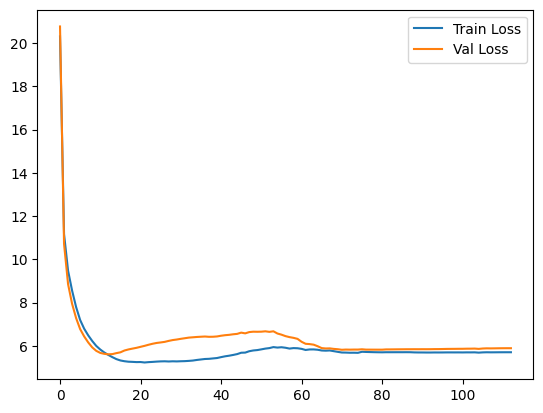

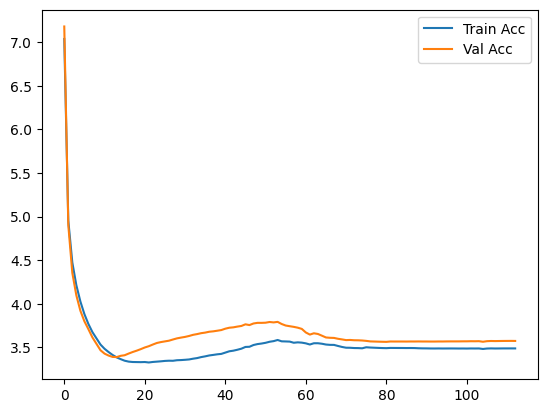

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs:  20%|██        | 203/1000 [00:28<01:52,  7.08it/s]


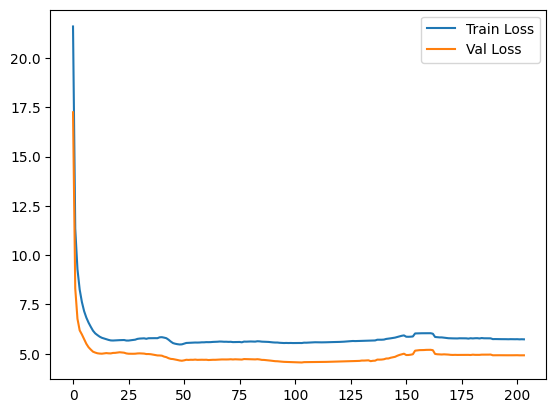

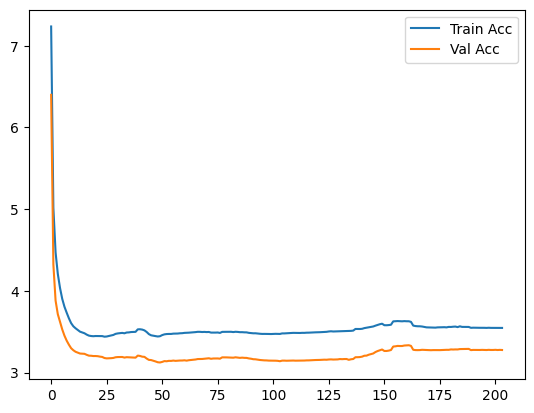

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs:  17%|█▋        | 173/1000 [00:24<01:55,  7.14it/s]


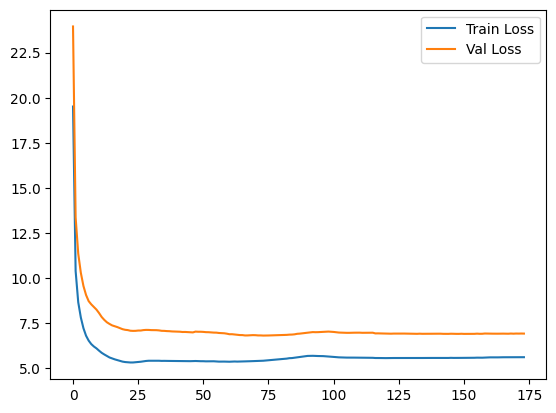

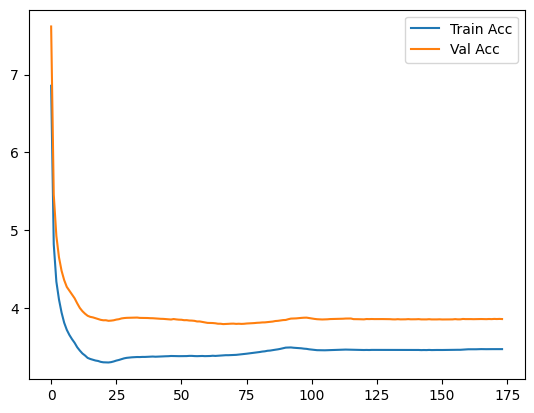

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs:  12%|█▏        | 116/1000 [00:15<01:57,  7.54it/s]


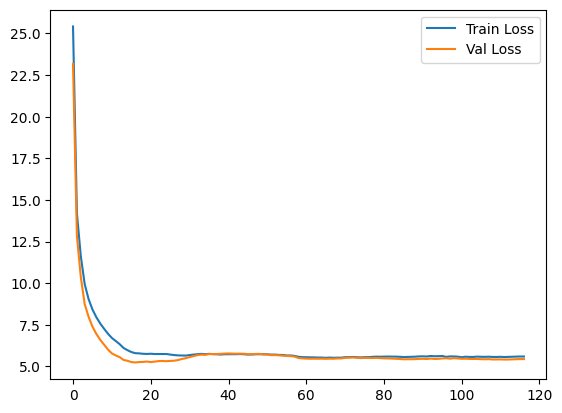

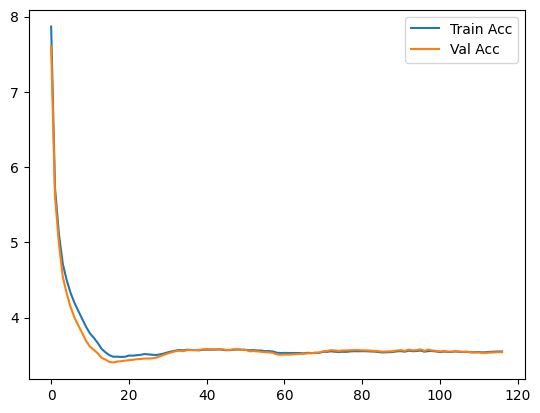

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs:  22%|██▏       | 220/1000 [00:29<01:46,  7.35it/s]


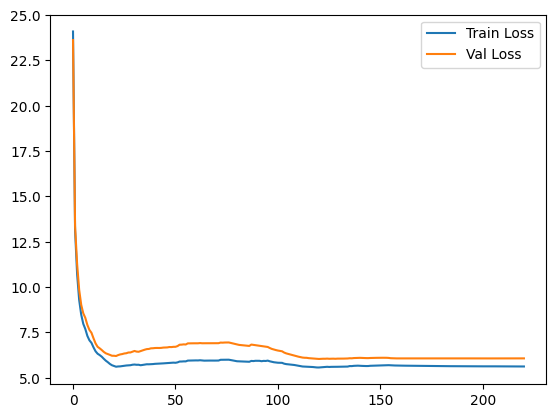

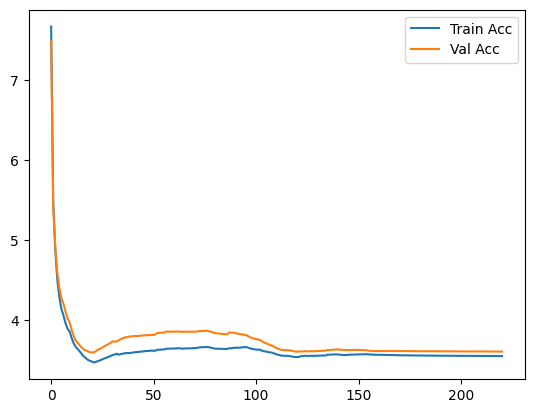

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs:  19%|█▉        | 192/1000 [00:24<01:44,  7.74it/s]


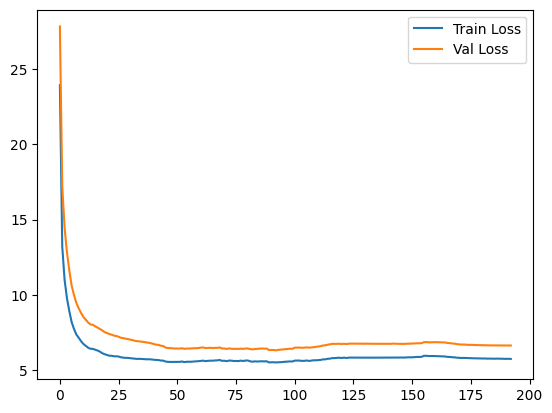

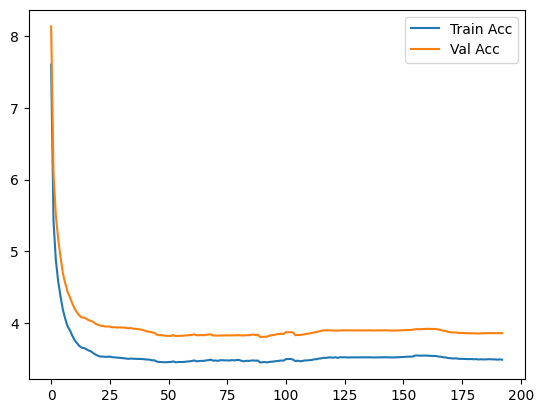

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)
{'tr_loss': 5.666189004842966, 'tr_metric': 3.5143336108118053, 'val_loss': 5.977712088742062, 'val_metric': 3.6177807091987617}




('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs:  60%|█████▉    | 596/1000 [01:13<00:50,  8.07it/s]


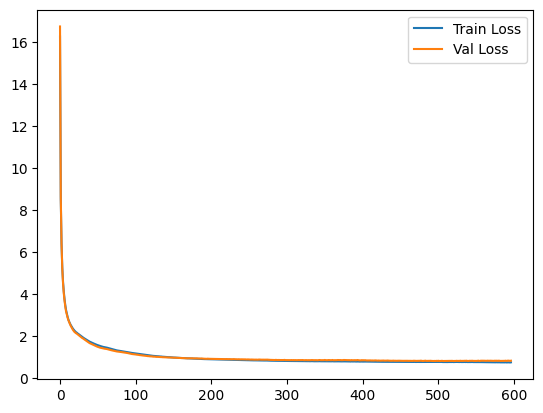

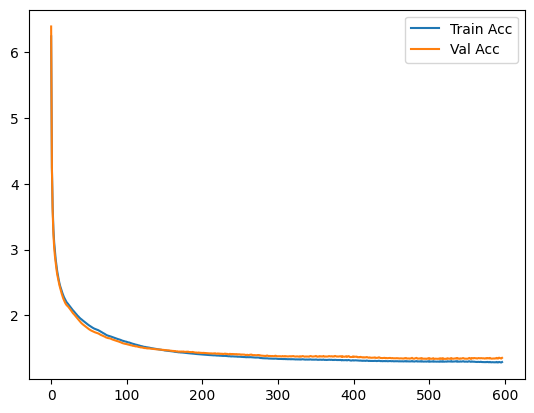

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs: 100%|██████████| 1000/1000 [02:05<00:00,  7.96it/s]


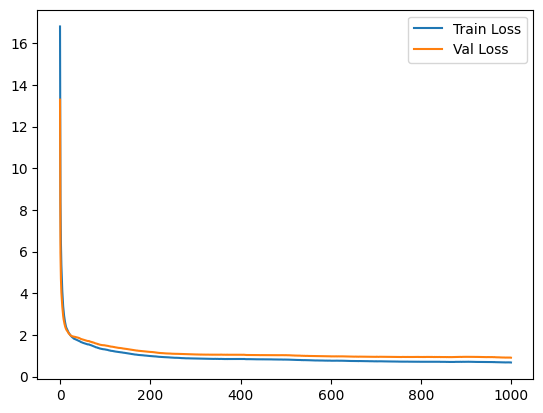

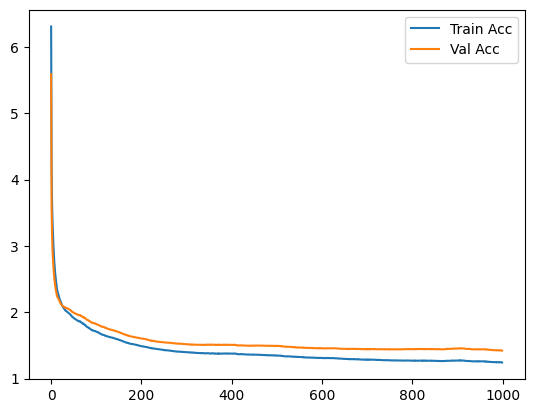

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs:  77%|███████▋  | 768/1000 [01:34<00:28,  8.17it/s]


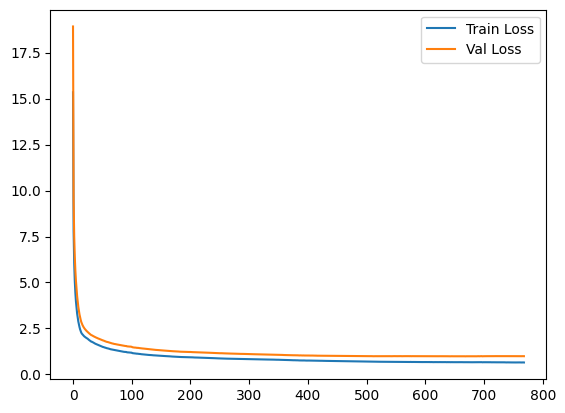

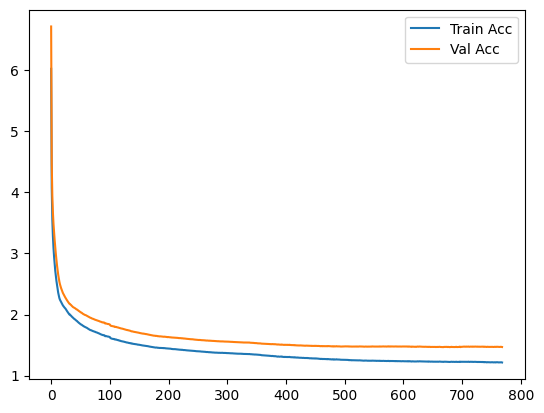

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs: 100%|██████████| 1000/1000 [02:03<00:00,  8.13it/s]


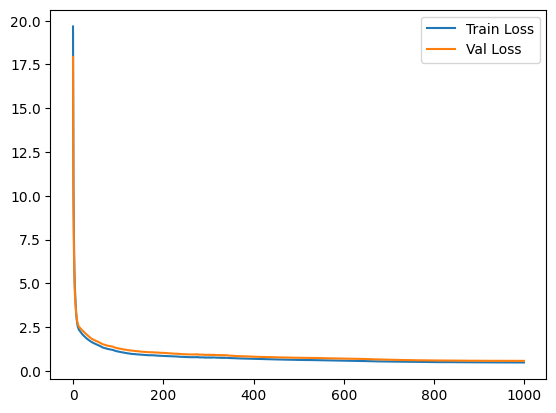

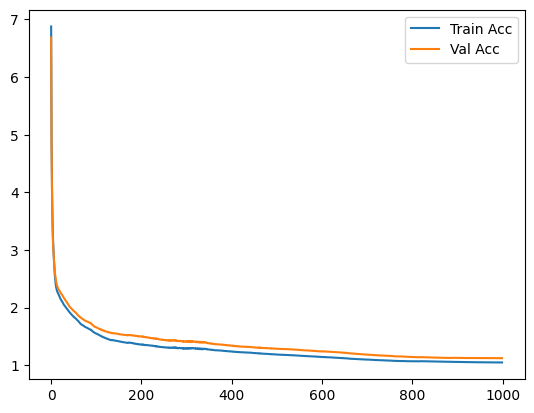

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs: 100%|██████████| 1000/1000 [02:03<00:00,  8.13it/s]


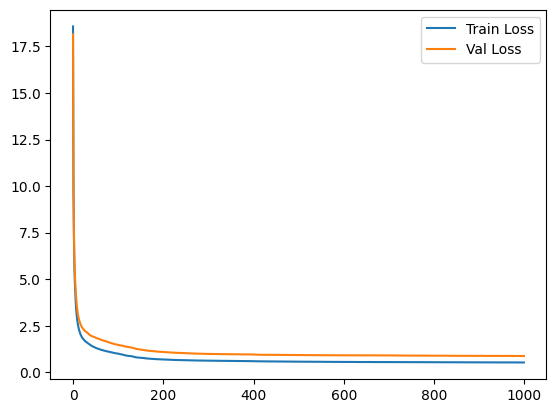

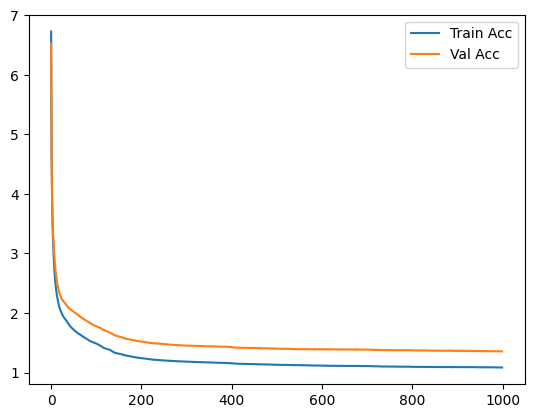

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)


Epochs: 100%|██████████| 1000/1000 [02:02<00:00,  8.14it/s]


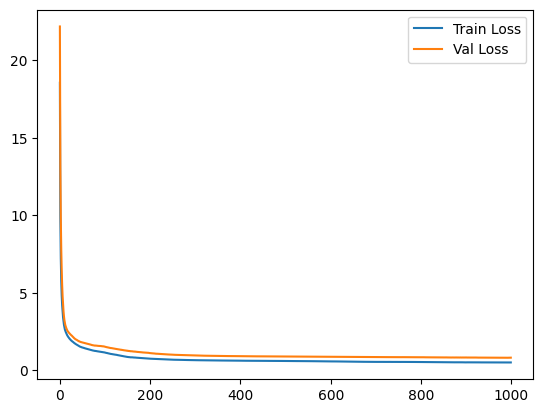

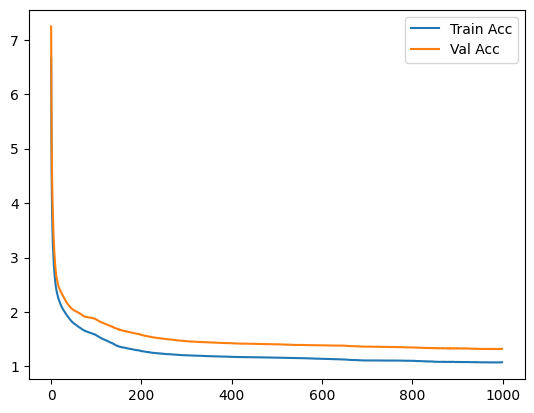

('Standard', 1e-06)
('Standard', 1e-06)
('Standard', 1e-06)
{'tr_loss': 0.5990340969249471, 'tr_metric': 1.1588285119761315, 'val_loss': 0.8318329362944937, 'val_metric': 1.3401544095325975}






In [34]:
seed = 3

for h in range(len(hyperparameters)):
    activations_ = []
    startings_ = []
    startings_range_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    etas_ = hyperparameters[h][8]
    for i in range(len(layers_sizes[0])):
        activations_.append(hyperparameters[h][3] if i != len(layers_sizes[0])-1 else "Identity")
        startings_.append(hyperparameters[h][2])
        startings_range_.append(hyperparameters[h][7])
        regularizers_.append(hyperparameters[h][4])
        regularizers_lambda_.append(hyperparameters[h][5])
        momentums_.append(hyperparameters[h][6])
    net = create_all_net(
        seed=seed,
        loss="MSE",
        batch_size=1,
        input_size=len(X_train[0]),
        num_layer=3,
        layers_size=[16,16,3],
        activations=activations_,
        starting=startings_,
        starting_range=startings_range_,
        regularizers=regularizers_,
        regularizers_lambda=regularizers_lambda_,
        momentums=momentums_,
        eta=etas_
        )
    statistics = kfold_crossval(
        X=X_train,
        y=y_train,
        k=6,
        net=net,
        epochs=1000,
        patience=100,
        seed=seed,
        metric=MEE()
        )
    print(statistics)
    print("\n\n\n")
